In [0]:
from keras.layers import Dense, Input, Flatten, Lambda, Dropout
from keras.models import Model
from keras.applications import VGG19
from keras.optimizers import Adam, Adagrad
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [0]:
image_size = [224,224]
epochs = 5

batch_size = 32
train_path = 'train'
test_path = 'test'

In [0]:
image_files = glob(train_path + '/*/*.jp*g')
test_files = glob(test_path + '/*/*.jp*g')


In [0]:
folders = glob(train_path + '/*')

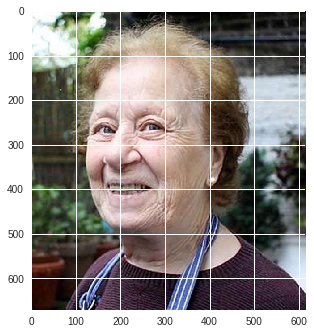

In [39]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
vgg = VGG19(include_top=False,input_shape=[224,224,3])

In [0]:
for layer in vgg.layers:
    layer.trainable = False

In [0]:
x = Flatten()(vgg.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(5,activation='softmax')(x)

In [0]:
model = Model(inputs=vgg.input, outputs=prediction)

In [57]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])


In [0]:
gen = ImageDataGenerator(rescale=1./255,rotation_range=20,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
               
                        )

In [60]:
test_gen = gen.flow_from_directory(test_path, target_size=(224,224))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 212 images belonging to 5 classes.
{'Bike': 0, 'Car': 1, 'Cat': 2, 'Dog': 3, 'Human': 4}


min: 0.09390653 max 1.0


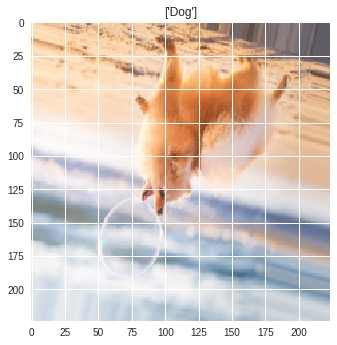

In [61]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [62]:
train_gen = gen.flow_from_directory(train_path, target_size=(224,224))


Found 740 images belonging to 5 classes.


In [63]:
r = model.fit_generator(train_gen,validation_data=test_gen,
                        epochs=15, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size)


Epoch 1/15
23/23 [==============================] - 45s 2s/step - loss: 1.5638 - acc: 0.4737 - val_loss: 0.8499 - val_acc: 0.6875
Epoch 2/15
23/23 [==============================] - 45s 2s/step - loss: 0.8561 - acc: 0.6502 - val_loss: 0.5984 - val_acc: 0.7188
Epoch 3/15
23/23 [==============================] - 43s 2s/step - loss: 0.7036 - acc: 0.6847 - val_loss: 0.6002 - val_acc: 0.6979
Epoch 4/15
23/23 [==============================] - 43s 2s/step - loss: 0.6520 - acc: 0.7119 - val_loss: 0.4775 - val_acc: 0.8073
Epoch 5/15
23/23 [==============================] - 43s 2s/step - loss: 0.5869 - acc: 0.7455 - val_loss: 0.4707 - val_acc: 0.8021
Epoch 6/15
23/23 [==============================] - 43s 2s/step - loss: 0.5066 - acc: 0.8067 - val_loss: 0.4056 - val_acc: 0.8229
Epoch 7/15
23/23 [==============================] - 42s 2s/step - loss: 0.5359 - acc: 0.7795 - val_loss: 0.4000 - val_acc: 0.8490
Epoch 8/15
23/23 [==============================] - 41s 2s/step - loss: 0.4548 - acc: 0.81

In [69]:
model.evaluate_generator(test_gen)

[0.3592726374572178, 0.8632075494190432]

In [70]:
model.evaluate_generator(train_gen)

[0.30740078077022287, 0.8932432432432432]

In [0]:
def get_confusion_matrix(data_path, N):
    print('generating confusion_matrix')
    predictions = []
    targets = []
    for x,y in gen.flow_from_directory(data_path, target_size=(224,224),shuffle=False):
        p = model.predict(x)
        p = np.argmax(p, axis = 1)
        y = np.argmax(y, axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets, y))
        if len(targets)>=N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

In [72]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

generating confusion_matrix
Found 740 images belonging to 5 classes.
[[115   1   0   0   0]
 [  0 108   0   0   0]
 [  2   0 102  18  10]
 [  1   0  17 102  24]
 [  1   0   1   0 238]]


In [73]:
valid_cm = get_confusion_matrix(test_path, len(test_files))
print(valid_cm)


generating confusion_matrix
Found 212 images belonging to 5 classes.
[[41  3  1  0  1]
 [ 1 37  0  0  0]
 [ 1  1 24  4  7]
 [ 1  1  5 21  9]
 [ 0  0  0  0 54]]


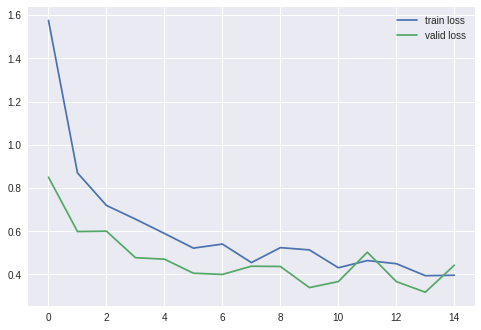

In [74]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

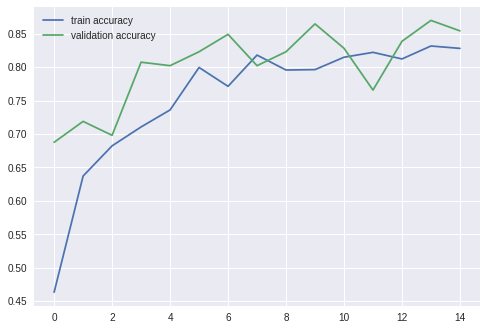

In [75]:
plt.plot(r.history['acc'], label = 'train accuracy')
plt.plot(r.history['val_acc'], label ='validation accuracy')
plt.legend()
plt.show()